In [1]:
import os
import random
import torch
import math
import pickle
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset ,ConcatDataset
from Data.MyDataSet import MultiMaskTimeSeriesDataset
import PRMAN

d:\Anaconda\envs\DL_env\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] 找不到指定的程序。'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
d:\Anaconda\envs\DL_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### PC_loss

In [2]:
class PCLoss(nn.Module):
    def __init__(self, VC ,factor,margin=0.04 ,max_loss=100 ):
        super(PCLoss, self ).__init__() 
        self.relu = nn.ReLU(inplace=True)
        self.VC = VC
        self.margin = margin
        self.max_loss = max_loss
        self.factor = factor 
    def forward(self, x):
        PC_loss , temp_loss, spat_loss = self.get_weight_matrix(x, self.VC ,self.margin ,self.max_loss)
        return self.factor[0] * PC_loss  + self.factor[1] * temp_loss + self.factor[2] * spat_loss
    
    def get_weight_matrix(self, speed_matrix, VC, margin=0.04, max_loss=100 ):
        # break when the masked_percent is larger than the max_masked_percent
        # masked_percent = masked_percent_per_update * current_update_count
        # if masked_percent > max_masked_percent * 100:
        #    return np.array([0])
        
        
        # consecutive constraint of the matrix
        # temporal consecutive
        temporal_anchor_matrix = speed_matrix[:, :, 1:-1, :]
        temporal_last_matrix = speed_matrix[:, :, 0:-2, :]
        temporal_next_matrix = speed_matrix[:, :, 2:, :]
        temporal_loss_1 = torch.square(temporal_anchor_matrix - temporal_last_matrix)
        temporal_loss_2 = torch.square(temporal_anchor_matrix - temporal_next_matrix)
        temporal_loss = torch.add(temporal_loss_1, temporal_loss_2)
        consecutive_margin = torch.Tensor([self.margin]).cuda()
        temporal_loss = torch.maximum(consecutive_margin, temporal_loss)
        temporal_loss = torch.where(temporal_loss > 400, 30, temporal_loss)
        temporal_loss = torch.mean(temporal_loss)

        # spatial consecutive
        spatial_anchor_matrix = speed_matrix[:, :, :, 1:-1]
        spatial_left_matrix = speed_matrix[:, :, :, 0:-2]
        spatial_right_matrix = speed_matrix[:, :, :, 2:]
        spatial_loss_1 = torch.square(spatial_anchor_matrix - spatial_left_matrix)
        spatial_loss_2 = torch.square(spatial_anchor_matrix - spatial_right_matrix)
        spatial_loss = torch.add(spatial_loss_1, spatial_loss_2)
        spatial_loss = torch.maximum(consecutive_margin, spatial_loss)
        spatial_loss = torch.where(spatial_loss > 900 ,50 ,spatial_loss)
        spatial_loss = torch.mean(spatial_loss)

        # sum of the consecutive_loss
        # Consecutive_loss = spatial_loss + temporal_loss

        # dynamic loss
        # get anchor, last and upstream matrix first
        anchor_matrix = speed_matrix[:, :, 1:, :-1]
        last_matrix = speed_matrix[:, :, :-1, :-1]
        upstream_matrix = speed_matrix[:, :, :-1, 1:]

        # for elements which are greater than VC
        IG_l = torch.greater(last_matrix, VC)
        IG_u = torch.greater(upstream_matrix, VC)
        IG = torch.eq(IG_l, IG_u)
        IG = IG.float()
        free_flow_loss = margin - (upstream_matrix - last_matrix) * (anchor_matrix - last_matrix)
        # print('free_flow_loss_1',torch.mean(free_flow_loss))
        free_flow_loss = self.relu(free_flow_loss)
        free_flow_loss = free_flow_loss * IG
        # print(torch.mean(free_flow_loss))

        # for elements which are not greater than VC
        IL_l = torch.less(last_matrix, VC)
        IL_u = torch.less(upstream_matrix, VC)
        IL = torch.eq(IL_l, IL_u)
        IL = IL.float()
        congested_loss = margin -(upstream_matrix - last_matrix) * (last_matrix - anchor_matrix)
        congested_loss = self.relu(congested_loss)
        congested_loss = congested_loss * IL
        # print(torch.mean(congested_loss))

        # merge the free flow and congested loss
        PC_loss = free_flow_loss + congested_loss
        # print(torch.mean(PC_loss))
        
        PC_loss = torch.where(PC_loss > max_loss, 0, PC_loss)
        
        PC_loss = torch.mean(PC_loss)

        return PC_loss ,temporal_loss, spatial_loss


### Trainer

In [4]:
### Trainer

class Trainer():
    def __init__(self,Generator, dataloader , Gen_lr,p_hint ,device , lr_scheduler=None , gamma = 0.2 ,PC_loss=None):
        '''
        Generator: Generator model
        Discriminator: Discriminator model
        dataloader: DataLoader object
        Gen_lr: Learning rate for the generator
        Dis_lr: Learning rate for the discriminator
        x_dim: Dimension of the input data
        device: 'cuda' or 'cpu'
        alpha: Hyperparameter for the generator loss
        p_hint: Probability of hint vector
        lr_scheduler: Learning rate scheduler
        '''
        self.Generator = Generator

        self.dataloader = dataloader
        self.device = device
        self.Gen_lr = Gen_lr
        self.p_hint = p_hint
        self.PC_loss = PC_loss
        
        self.optimizer_G = optim.Adam(Generator.parameters(), lr=Gen_lr, betas=(0, 0.9))
        
        if lr_scheduler is not None:
            self.lr_scheduler_G = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer_G, mode='min',threshold=0.00005, factor=gamma, patience=10, verbose=True)
            
        
        self.graph = {'iter':[],'G_loss': [], 'D_loss': [], 'MSE_train_loss': [], 'MSE_test_loss': []}
        self.total_iter = 0
        
        # self.noise_z = self.sample_noise(x_dim)
        
    def sample_noise(self, dim):
        return torch.rand(dim).to(self.device)
    
    # hint Vector Generation
    def sample_hint(self, dim, p):
        A=torch.rand(dim,dtype=torch.float16).to(self.device)
        A[A>p]=1.0
        A[A<=p]=0
        return A
    
    def generator_loss(self,x_raw,mask,x_mask_noise,Hint=None):
        '''
        x_raw: Real data
        x_gen: Generated data
        mask: Masked data 1:raw, 0:gen
        x_Hat: Combined data : mask * x_raw + (1 - mask) * x_gen
        '''
        x_input = torch.cat([x_mask_noise,mask], dim=1)    
        x_gen = self.Generator(x_input)

        MSE_train_loss = torch.mean((mask * x_mask_noise - mask * x_gen)**2)/torch.mean(mask)
        MSE_test_loss = torch.mean(((1 - mask) * x_raw - (1 - mask) * x_gen)**2)/torch.mean(1 - mask)
        if self.PC_loss is not None:
            PC_loss = self.PC_loss(x_gen)
        else :
            PC_loss = None
            
        if Hint is not None:
            temp= (1-mask).bool()
            MAPE_test_loss = torch.mean(torch.abs(( x_raw[temp] -  x_gen[temp])/ (1e-2+x_raw[temp]) ))
        else :
            MAPE_test_loss = None
        return  MSE_train_loss, MSE_test_loss , PC_loss , MAPE_test_loss
        

    
    def test(self , test_dataloader ):
        self.Generator.eval()
        result = {'x_raw':[],'mask': [], 'G_loss': [], 'MSE_train_loss': [], 'MSE_test_loss': [], 'MAPE_test_loss':[]}
        
        with torch.no_grad():
            for x_raw, mask in test_dataloader:
                x_raw = x_raw.float().to(self.device).unsqueeze(1)
                mask = mask.float().to(self.device).unsqueeze(1) 
                # print(x_raw.shape,mask.shape)
                x_mask_noise = mask * x_raw + (1 - mask) * self.sample_noise(x_raw.shape).to(self.device)

                MSE_train_loss, MSE_test_loss, pc_loss ,MAPE_test_loss = self.generator_loss(x_raw, mask, x_mask_noise,1)
                result['x_raw'].append(x_raw)
                result['mask'].append(mask)
                result['MSE_train_loss'].append(MSE_train_loss.item())
                result['MSE_test_loss'].append(MSE_test_loss.item())
                result['MAPE_test_loss'].append(MAPE_test_loss.item())

                # print('Generator Loss: {:.4f}, MSE Train Loss: {:.4f}, MSE Test Loss: {:.4f}'.format(G_loss.item(), MSE_train_loss.item(), MSE_test_loss.item()))
        
        return result
        
    def train(self, epochs,save_path=None , test_dataloader=None):
        self.Generator.train()
        
        if test_dataloader is not None:
            test_graph = {'test_epochs':[], 'test_MSE_train_loss': [], 'test_MSE_test_loss': [] ,'test_lr':[]}

        print('Training...')
        for it in tqdm(range(epochs)):
            for x_raw, mask in self.dataloader:
                self.total_iter = self.total_iter + 1
                x_raw = x_raw.float().to(self.device).unsqueeze(1)
                mask = mask.float().to(self.device).unsqueeze(1)
                
                # print(x_raw.shape, mask.shape)
                x_mask_noise = mask * x_raw + (1 - mask) * self.sample_noise(x_raw.shape)
                # hint = self.sample_hint(mask.shape, 1.0-self.p_hint)
                # mask_hint = mask * hint
                
                
                # Train Generator
                self.optimizer_G.zero_grad()
                MSE_train_loss, MSE_test_loss, PC_loss,_ = self.generator_loss(x_raw, mask, x_mask_noise)
                if PC_loss is None:
                    total_loss = MSE_train_loss + MSE_test_loss 
                else :
                    total_loss = MSE_train_loss + MSE_test_loss + PC_loss
                total_loss.backward()
                self.optimizer_G.step()
                
                if self.total_iter % 256 ==0:
                    self.graph['iter'].append(self.total_iter)
                    self.graph['MSE_train_loss'].append(MSE_train_loss.item())
                    self.graph['MSE_test_loss'].append(MSE_test_loss.item())
                
                # print('MSE_train_loss:',MSE_train_loss.item())
                
                # break
            if test_dataloader is not None:
                result = self.test(test_dataloader)
                self.lr_scheduler_G.step(np.mean(result['MSE_test_loss']))
                
                test_graph['test_epochs'].append(epochs)
                test_graph['test_MSE_train_loss'].append(np.mean(result['MSE_train_loss']))
                test_graph['test_MSE_test_loss'].append(np.mean(result['MSE_test_loss']))
                test_graph['test_lr'].append(self.optimizer_G.param_groups[0]['lr'])
                
            
            if it%2==0:
                print('Epoch: {}, Generator Loss: {:.4f}, MSE Train Loss: {:.4f},  MSE Test Loss: {:.4f}, lr :{}' \
                      .format(it, total_loss.item(), MSE_train_loss.item(), MSE_test_loss.item(), self.optimizer_G.param_groups[0]['lr']) )
                
            if save_path is not None and (it+1)%20==0:
                if not os.path.exists(save_path):
                    os.makedirs(save_path)
                self.save_checkpoint(os.path.join(save_path,'checkpoint_{}.pth'.format(it)))
        
        if save_path is not None:
            if not os.path.exists(save_path):
                    os.makedirs(save_path)
            self.save_graph(os.path.join(save_path,'Train_record.pkl'))
        
        print('Training finished!')
        
        if test_dataloader is not None:
            return test_graph
    
    def save_checkpoint(self,path):
        torch.save({'Generator_state_dict': self.Generator.state_dict(),
                    'optimizer_G_state_dict': self.optimizer_G.state_dict()}, path)
        
    def save_graph(self,path):
        with open(path, 'wb') as f:
            pickle.dump(self.graph, f)
    
    def load_checkpoint(self,path):
        checkpoint = torch.load(path)
        self.Generator.load_state_dict(checkpoint['Generator_state_dict'])
        self.optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])

    def plot_graph(self,graph):

        plt.figure(figsize=(16, 9))
        # plt.subplot(2, 2, 1)
        # plt.plot(graph['iter'], graph['G_loss'])
        # plt.xlabel('Iteration')
        # plt.ylabel('Generator Loss')
        # plt.title('Generator Loss')
        
        
        plt.subplot(1, 2, 1)
        plt.plot(graph['iter'], graph['MSE_train_loss'])
        plt.xlabel('Iteration')
        plt.ylabel('MSE Train Loss')
        plt.title('MSE Train Loss')
        
        plt.subplot(1, 2, 2)
        plt.plot(graph['iter'], graph['MSE_test_loss'])
        plt.xlabel('Iteration')
        plt.ylabel('MSE Test Loss')
        plt.title('MSE Test Loss')
        
        plt.show()
    
    def plot_test_graph(self,graph):

        plt.figure(figsize=(16, 9))

        plt.subplot(1, 2, 1)
        plt.plot(graph['test_epochs'], graph['test_MSE_train_loss'])
        plt.xlabel('Epochs')
        plt.ylabel('TestSet MSE Train Loss')
        plt.title('TestSet MSE Train Loss')
        
        plt.subplot(1, 2, 2)
        plt.plot(graph['test_epochs'], graph['test_MSE_test_loss'])
        plt.xlabel('Epochs')
        plt.ylabel('TestSet MSE Test Loss')
        plt.title('TestSet MSE Test Loss')
        
        # plt.subplot(2, 2, 4)
        # plt.plot(graph['test_epochs'], graph['test_lr'])
        # plt.xlabel('Epochs')
        # plt.ylabel('TestSet Learning Rate')
        # plt.title('TestSet Learning Rate')
        
        plt.show()
    

### load_dataset

In [5]:
source_train_path = r'D:\WorkPath\Models\ImputeFormer\Data\source_train_METRLA(70)'
source_train_files = os.listdir(source_train_path)
source_train_files = [os.path.join(source_train_path, file) for file in source_train_files]
source_train_data = []

for file_path in source_train_files:
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    source_train_data.append(data)

data = ConcatDataset(source_train_data)
data_loader = DataLoader(data, batch_size=32, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

len(data)

45600

### Training

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PRMAN.PRMAN(img_size=(48,32), patch_size=4, in_chans=2, out_chans=1,
            embed_dim=48, depths=[3, 3, 3, 3], num_heads=[6, 6, 6, 6],
            window_size=8, mlp_ratio=4., qkv_bias=True, qk_scale=None,
            drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
            norm_layer=nn.LayerNorm, ape=False, patch_norm=False,
            use_checkpoint=False, upscale=1, img_range=1., upsampler='', 
            resi_connection='3conv').to(device)  # 实例化 PRMAN 模型

pc_loss= PCLoss(VC=30 , factor=[0.1,0.1,0.1] ,margin=0.04  , max_loss = 100)


trainer = Trainer(model, data_loader, Gen_lr=1e-4, p_hint= 0.1, device=device , PC_loss=pc_loss) 
trainer.train(epochs=150, save_path=r'D:\WorkPath\Models\PRMAN\Checkpoints70(01)')  

d:\Anaconda\envs\DL_env\lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [40]:
project_path = r'D:\WorkPath\Models\ImputeFormer'
test_path = os.path.join(project_path , r'Data\source_test_METRLA(70)') 
test_files = os.listdir(test_path)
test_files = [os.path.join(test_path, file) for file in test_files]
test_record = {'data_name':[],'MSE_train_loss':[] , 'MSE_test_loss':[], 'MAPE_test_loss':[]}

trainer.load_checkpoint(r'D:\WorkPath\Models\PRMAN\Checkpoints70\checkpoint_159.pth')

for file_path in test_files:
    with open(file_path, 'rb') as f:
        test_data = pickle.load(f)
    test_data_loader = DataLoader(test_data, batch_size=16, shuffle=False)
    result=trainer.test(test_data_loader)
    test_record['data_name'].append(file_path)
    test_record['MSE_train_loss'].append(np.mean(result['MSE_train_loss'][1:]))
    test_record['MSE_test_loss'].append(np.mean(result['MSE_test_loss'][1:]))
    test_record['MAPE_test_loss'].append(np.mean(result['MAPE_test_loss'][1:]))
test_record = pd.DataFrame(test_record)
test_record['route']=test_record['data_name'].apply(lambda x :x.split('_')[5])
test_record['start']=test_record['data_name'].apply(lambda x :x.split('_')[-3])
test_record['miss_rate']=test_record['data_name'].apply(lambda x :x.split('_')[-2])
test_record['type']=test_record['data_name'].apply(lambda x :x.split('_')[-1][:-4])
test_record=test_record[['route','start','miss_rate','type','MSE_train_loss','MSE_test_loss', 'MAPE_test_loss']]
test_record=test_record.sort_values(['route','type','start'])
test_record

,route,start,miss_rate,type,MSE_train_loss,MSE_test_loss,MAPE_test_loss
0,006-11,0,70,block,0.240493,58.881528,0.140490
1,006-11,0,70,linear,0.167837,91.497884,0.202383
2,006-11,0,70,mixed,0.292932,56.096697,0.152832
3,006-11,0,70,random,0.317112,31.448376,0.105919
4,006-15,0,70,block,0.377385,63.989314,0.227725
5,006-15,0,70,linear,0.273474,106.504628,0.308421
6,006-15,0,70,mixed,0.408867,60.234382,0.219892
7,006-15,0,70,random,0.576783,38.661167,0.172206
8,006-19,0,70,block,0.167004,37.681832,0.092837
9,006-19,0,70,linear,0.117291,67.049471,0.157634


In [41]:
test_record.groupby('type')[['MSE_test_loss','MAPE_test_loss']].mean()

,MSE_test_loss,MAPE_test_loss
type,,
block,51.695253,0.147156
linear,82.924780,0.207172
mixed,47.740184,0.149168
random,28.084012,0.107566


In [16]:
test_record.to_csv(r'D:\WorkPath\Models\PRMAN\test_record70(01).csv')

In [17]:
test_record.groupby('type')[['MSE_test_loss','MAPE_test_loss']].mean().to_csv(r'D:\WorkPath\Models\PRMAN\G70(01).csv')

In [18]:
trainer.save_checkpoint(r'D:\WorkPath\Models\PRMAN\Save\checkpoint_20240927.pth')

In [4]:
import pickle
with open(r'D:\WorkPath\Models\PRMAN\Save\Train_record_20240821.pkl', 'rb') as f:
    record = pickle.load(f)
record.keys()

dict_keys(['iter', 'G_loss', 'D_loss', 'MSE_train_loss', 'MSE_test_loss'])

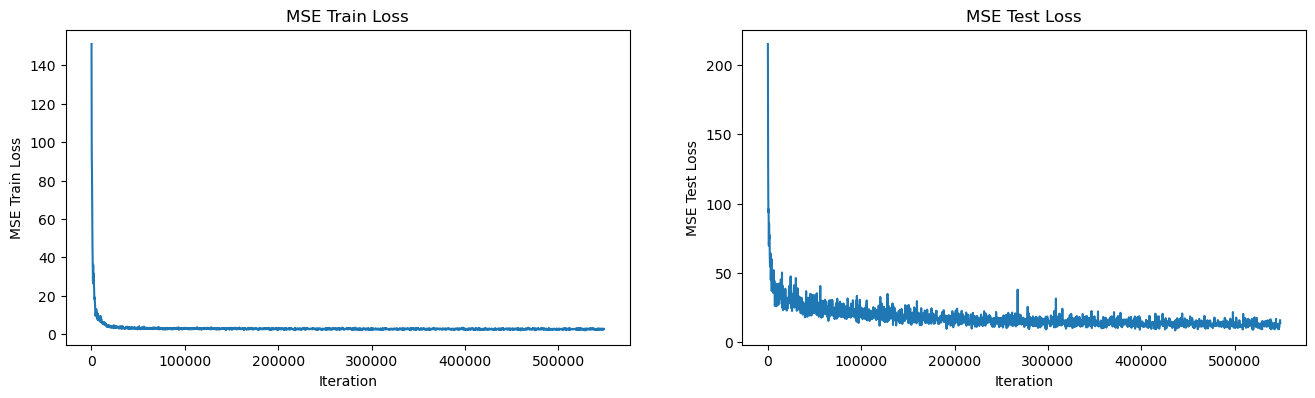

In [6]:
plt.figure(figsize=(16, 9))
# plt.subplot(2, 2, 1)
# plt.plot(record['iter'], record['G_loss'])
# plt.xlabel('Iteration')
# plt.ylabel('Generator Loss')
# plt.title('Generator Loss')

# plt.subplot(2, 2, 2)
# plt.plot(record['iter'], record['D_loss'])
# plt.xlabel('Iteration')
# plt.ylabel('Discriminator Loss')
# plt.title('Discriminator Loss')

plt.subplot(2, 2, 3)
plt.plot(record['iter'], record['MSE_train_loss'])
plt.xlabel('Iteration')
plt.ylabel('MSE Train Loss')
plt.title('MSE Train Loss')

plt.subplot(2, 2, 4)
plt.plot(record['iter'], record['MSE_test_loss'])
plt.xlabel('Iteration')
plt.ylabel('MSE Test Loss')
plt.title('MSE Test Loss')

plt.show()